# OBJECTIVE: build an XGBoost classifier to predict credit default based on a dataset. 

In [1]:

#Import necessary libaries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%pip install xgboost #Install the XGBoost library

import xgboost as xgb

#Load the dataset
url = 'https://github.com/Safa1615/Dataset--loan/blob/main/bank-loan.csv?raw=true'
data = pd.read_csv(url, nrows=700) #nrows is used to read only the first 700 rows

Note: you may need to restart the kernel to use updated packages.


In [2]:
print(data.columns) #prints the column names, this begins the dataset exploration. 

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')


Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')


In [3]:
# Display the first few rows of the dataset

print(data.head()) # important to note the number of rows I want to view can be adjusted with the number in the brackets. Default, or none added is 5.

#this proves that the data was imported correctly... at least for the first 5 rows. It also allows some epxloration of the dataset in order to understand 
# the values expected.

   age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0   41   3      17       12     176      9.3  11.359392  5.008608        1
1   27   1      10        6      31     17.3   1.362202  4.000798        0
2   40   1      15       14      55      5.5   0.856075  2.168925        0
3   41   1      15       14     120      2.9   2.658720  0.821280        0
4   24   2       2        0      28     17.3   1.787436  3.056564        1


In [4]:
# Descriptive statistics for the dataset. 

print(data.describe())

# the first row, count, validates that each column has 700 values. This is important to ensure that there are no missing values in the dataset.

# the mean provides an understanding of the average for each data column. For example, the mean age is 34.86, the mean income is 45.6k
# and the  mean year living at the primary residency is 8.2 years. 

# Other descriptive statistics can be viewed, but do not appear to be necessary for this analysis.

              age          ed      employ     address      income     debtinc  \
count  700.000000  700.000000  700.000000  700.000000  700.000000  700.000000   
mean    34.860000    1.722857    8.388571    8.278571   45.601429   10.260571   
std      7.997342    0.928206    6.658039    6.824877   36.814226    6.827234   
min     20.000000    1.000000    0.000000    0.000000   14.000000    0.400000   
25%     29.000000    1.000000    3.000000    3.000000   24.000000    5.000000   
50%     34.000000    1.000000    7.000000    7.000000   34.000000    8.600000   
75%     40.000000    2.000000   12.000000   12.000000   55.000000   14.125000   
max     56.000000    5.000000   31.000000   34.000000  446.000000   41.300000   

         creddebt     othdebt     default  
count  700.000000  700.000000  700.000000  
mean     1.553553    3.058209    0.261429  
std      2.117197    3.287555    0.439727  
min      0.011696    0.045584    0.000000  
25%      0.369059    1.044178    0.000000  
50%   

In [5]:
# Checks the  data types
print(data.dtypes)

age           int64
ed            int64
employ        int64
address       int64
income        int64
debtinc     float64
creddebt    float64
othdebt     float64
default       int64
dtype: object


age           int64
ed            int64
employ        int64
address       int64
income        int64
debtinc     float64
creddebt    float64
othdebt     float64
default       int64
dtype: object


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

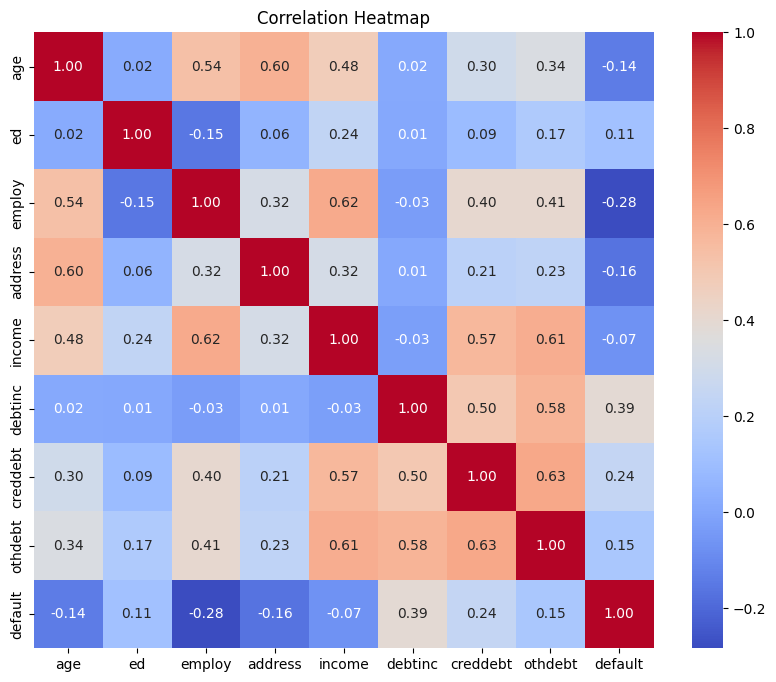

In [7]:
# Create a heatmap to visualize correlation between numeric variables
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# The heatmap shows the correlation between the numeric variables in the dataset. The correlation ranges from -1 to 1.
# a positive one would indicate that for each point increase in one variable, the other variable increases by the same amount.
# a negative one would indicate that for each point increase in one variable, the other variable decreases by the same amount.
# thus one can see the strength of the correlation of the variables depending on their color, as indicated by the key on the far right. 
# for example, a strong positive correlation can be seen between age and address. 
# Whereas a weak correlation exists between age and education. 
# The strongest negative correlation here is between employment and default. An interesting note. 

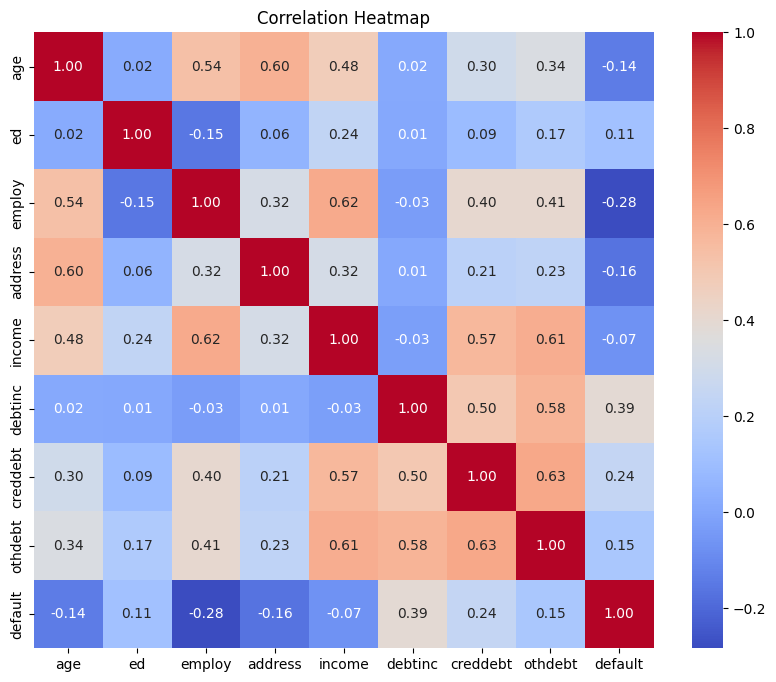

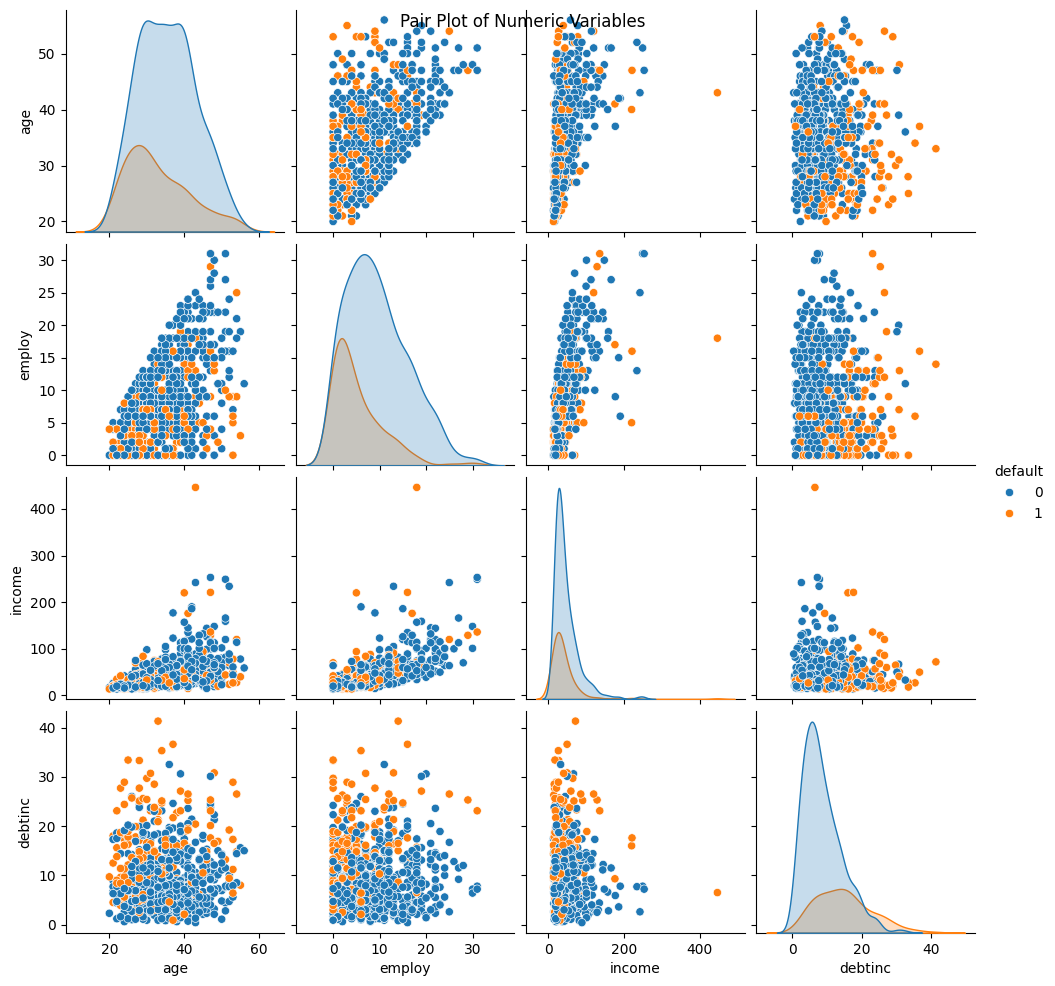

In [8]:
# Create a pair plot to visualize relationships between numeric variables
sns.pairplot(data, vars=['age', 'employ', 'income', 'debtinc'], hue='default')
plt.suptitle("Pair Plot of Numeric Variables")
plt.show()

# this pair plot is an excellent visualization tool to understand the relationships between the numeric variables in the dataset.
# For example, I really enjoyed viewing debt:income ratio compared with age. It showed an interesting note that age had little impacts in defaults rising,
# but the debt:income ratio had a significant increase in defaults as the ratio increased.

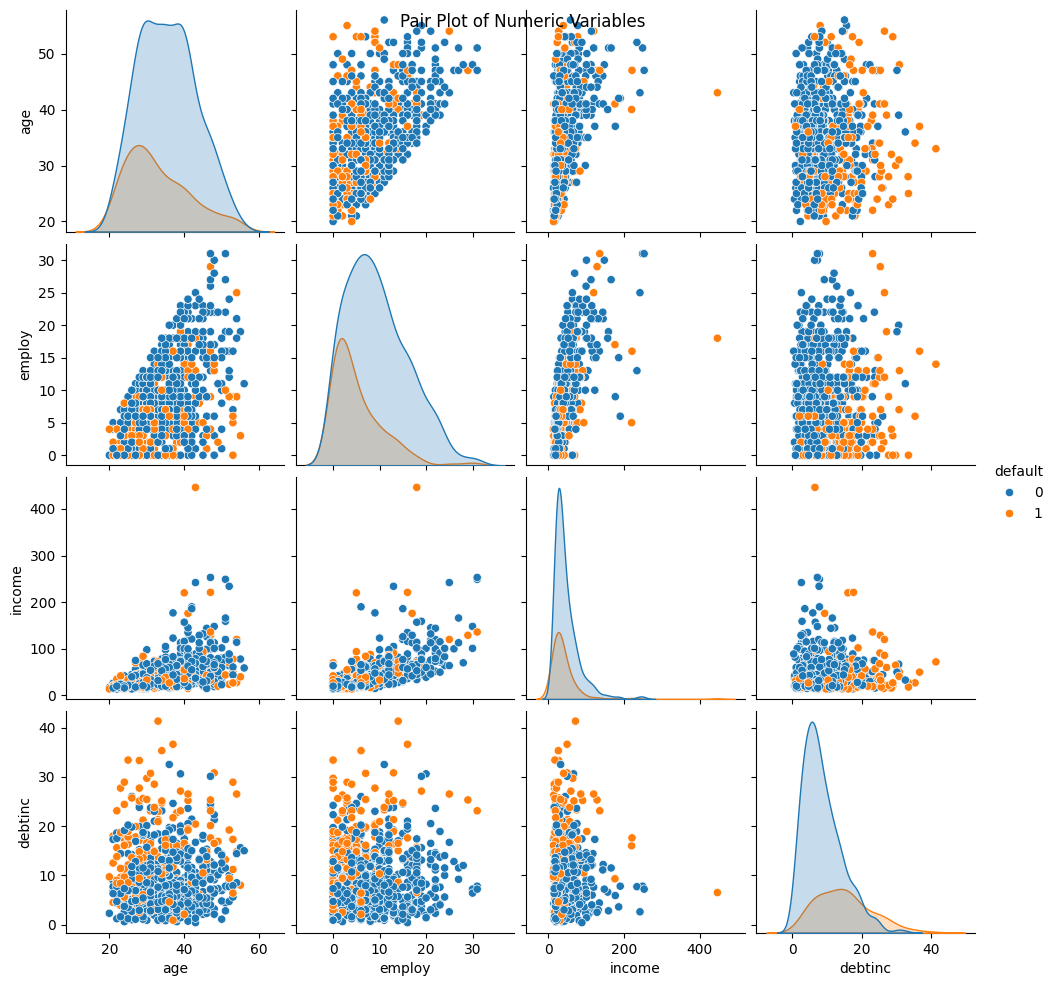

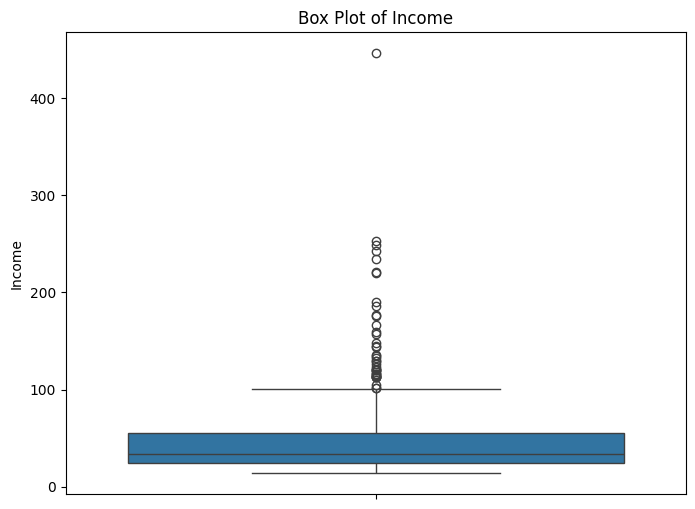

In [9]:
# Create a box plot to visualize the distribution of 'income', this concludes data exploration. 

plt.figure(figsize=(8, 6))
sns.boxplot(y='income', data=data)
plt.title("Box Plot of Income")
plt.ylabel("Income")

plt.show()

# really quite straight forward. This could be useful for removing outliers from the datasource. For example, this individual whose income is above 400k 
# should likely be removed as an outlier. 

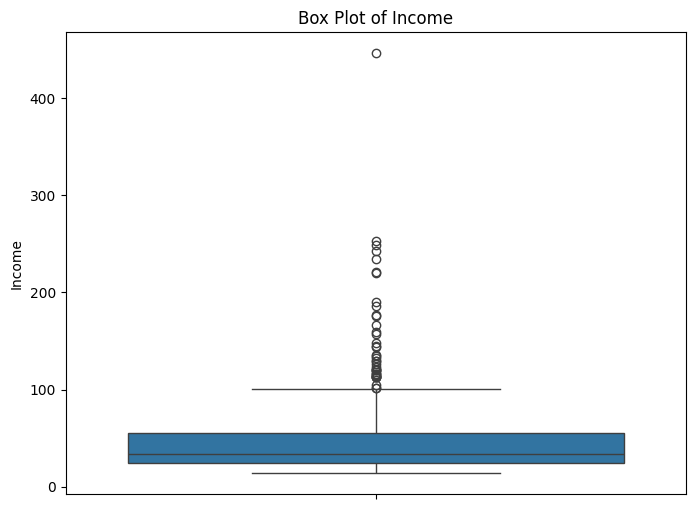

In [10]:
#Split the data into features (independent variables) and the target variable (default or not)

#this marks the data preprocessing stage. 

X = data.drop('default', axis=1)
y = data['default']

#Split the dataset into training and testing sets. Now data preprocessing is complete.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# because all columns above had 700 values, there is no need to check for missing values.
# No scaling nor dummy coding was done either. 

In [11]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


# this is the hyper parameter tuning section. 
# As you can see, I was quite interested in exploring how to utilize this. I haven't seen it before. 
# Define the parameter grid, this one was my original one. 

'''

param_grid = {

    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.47, 0.4999, 0.49999, 0.5, 0.50001, 0.55, 0.6, 0.7]

}

'''

# a new more optimized parameter grid to drill down on the best parameters.

'''   

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.48, 0.49, 0.495, 0.499, 0.4999, 0.49999, 0.5]
}

'''

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    'learning_rate': [0.48, 0.4825, 0.485, 0.4875, 0.49]
}


# Initialize the XGBoost classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Initialize the grid search
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)

{'learning_rate': 0.485, 'max_depth': 10}


In [12]:
#Interestingly, the above output reports that learning_rate = 0.485 and max_depth = 10 report the best results... 
{'learning_rate': 0.485, 'max_depth': 10}

{'learning_rate': 0.485, 'max_depth': 10}

In [14]:
#Initialize a classification model (in this case, an XGBoost classifier)

classifier = xgb.XGBClassifier(max_depth = 10, learning_rate = 0.485, random_state=42)

#Train the classifier on the training data
classifier.fit(X_train, y_train)

#Make prediction on the test data
y_pred = classifier.predict(X_test)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

#Print the results
print(f"Accuracy: {accuracy: .2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

Accuracy:  0.80
Confusion Matrix:
[[96  6]
 [22 16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       102
           1       0.73      0.42      0.53        38

    accuracy                           0.80       140
   macro avg       0.77      0.68      0.70       140
weighted avg       0.79      0.80      0.78       140



In [15]:

#when testing this settup v.s. the "optimal" setup, it can be seen that this out performs on accuracy and precision (for default = 0, or false).

classifier = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.45, random_state=42)

#Train the classifier on the training data
classifier.fit(X_train, y_train)

#Make prediction on the test data
y_pred = classifier.predict(X_test)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

#Print the results
print(f"Accuracy: {accuracy: .2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

# this model had more true positive analyses, less true negatives, more false negatives, and less false positives. 
# However, it does not outperform on recall. It does on precision. It does on accuracy. The F1 scores are equal for default = 0, but slightly 
# underperforms for default = 1.

#as such, I would likely utilize this model 100% of the time. Unless false negatives were specifically very important. 

Accuracy:  0.81
Confusion Matrix:
[[94  8]
 [19 19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       102
           1       0.70      0.50      0.58        38

    accuracy                           0.81       140
   macro avg       0.77      0.71      0.73       140
weighted avg       0.80      0.81      0.80       140



# FINAL REFLECTION!!! 

Overall, this was an interesting delve into utilizing XGBoost as an epic tool for analyzing credit default risk. 

That said, after doing some research the utilization of this model may be problematic. 

This is because XGBoost while epic in terms of its predictive software power, data type flexiblity, and missing value accomodation... it's quite complex
and therefore low in ability to be explained. As such, it may not be valid to use in a level 2 or above credit risk model. 